In this notebook, we will make ARIMA(Autoregressive Integrated Moving Average) & SARIMAX(Seasonal Autoregressive Integrated Moving Average + exogenous variables) model based on preprocessed data.

Auto Regressive Integrated moving Average
 steps:
 1. plot a time series format
 2. make the time series data stationary
 3. plot ACF & PACF and identify the potential AR and MA model
 4. Construct the ARIMA model based on the data
 5. Use the model to make predictions
  

In [1]:
from matplotlib import pyplot  as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv("data/2010_2023_preprocessed_data.csv", index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3274 entries, 0 to 3273
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3274 non-null   object 
 1   Close   3274 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.7+ KB


In [3]:
data["Date"].head()

0    2010-04-07
1    2010-04-08
2    2010-04-09
3    2010-04-12
4    2010-04-13
Name: Date, dtype: object

In [4]:
data["Date"] = pd.to_datetime(data["Date"], format='%Y-%m-%d')

1) Plot a time series format

Text(0, 0.5, 'Price')

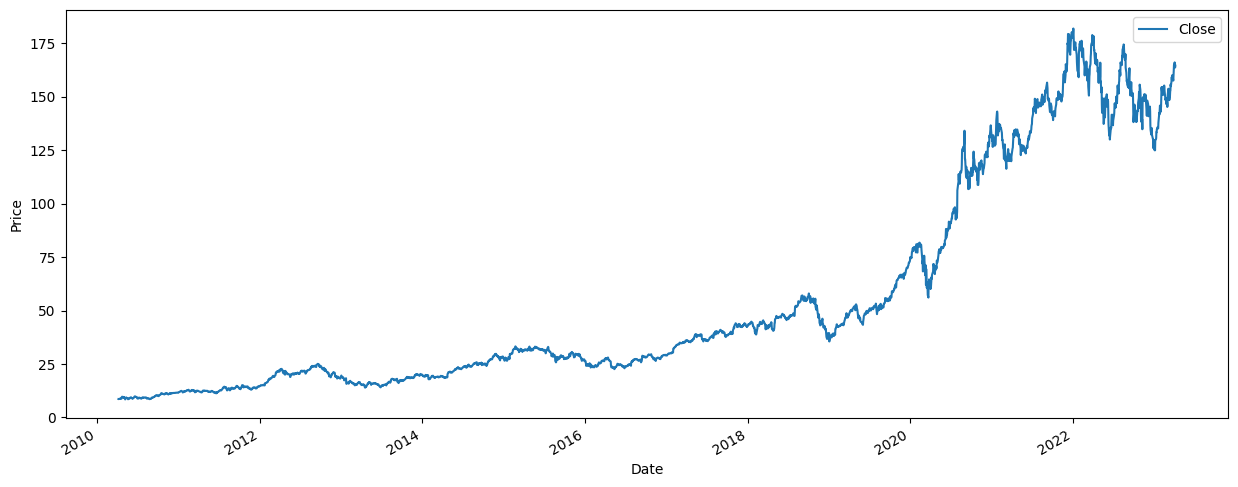

In [5]:
data.plot(x='Date', y='Close', figsize=(15,6))
plt.xlabel("Date")
plt.ylabel("Price")

2) Make the time series data stationary

* what is stationary data?
    * A time series is considered stationary if its statistical properties do not change over time. This means the mean, variance, and autocorrelation structure remain constant throughout the series.
    * Characteristics: Constant Mean, Constant Variance, Constant Autocorrelation Structure, No Trends

* what is non-stationary data?
    * A time series is non-stationary if its statistical properties change over time.
    * Characteristics: Changing Mean, Changing Variance, Changing Autocorrelation Structure, Presence of Trends and Seasonality

To make data stationary, we need to find if current data is stationary or not?

To check that we require Augmented Dickey-Fuller (ADF) Test.

In [6]:
test_results = adfuller(data["Close"])
# returns (Test Statistics, p value, number of lags, number of observations, critical values, icbest)

In [7]:
# H0 Null Hypotheses  --> series is stationary
# h1 Alternate Hypotheses  --> series is non stationary

def adfuller_test(price):
    results = adfuller(price)
    labels = ["Test Statistics", "p value", "number of lags", "number of observations", "critical values", "icbest"]
    for value,labels in zip(results, labels):
        print(f"{labels}: {value}")
    if results[1] <= 0.5:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [8]:
adfuller_test(data["Close"])

Test Statistics: 0.509015632191741
p value: 0.9851445584662851
number of lags: 22
number of observations: 3251
critical values: {'1%': -3.432363063934179, '5%': -2.862429451294045, '10%': -2.567243474020865}
icbest: 11550.640279743635
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


based on observations of ADF test, data is not stationary. so, we need to make it stationary and for approching that way we need to implement Differencing Technique.

How to calculate pvalue?

Differencing

In [9]:
data["Close First Difference"] = data["Close"] - data["Close"].shift(1)

In [10]:
adfuller_test(data["Close First Difference"].dropna())

Test Statistics: -11.910460169597629
p value: 5.311742359739089e-22
number of lags: 21
number of observations: 3251
critical values: {'1%': -3.432363063934179, '5%': -2.862429451294045, '10%': -2.567243474020865}
icbest: 11546.334720959436
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: >

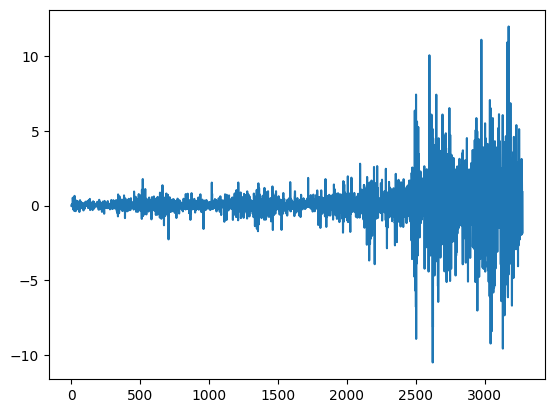

In [11]:
data["Close First Difference"].plot()

3) plot ACF & PACF and identify the potential AR and MA model

ACF: ACF indicates how similar a value is within a given time series and the previous value.

PACF: shows the correlation of the sequence with itself with some number of time units per sequence order in which only the direct effect has been shown, and all other intermediary effects are removed from the given time series.

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

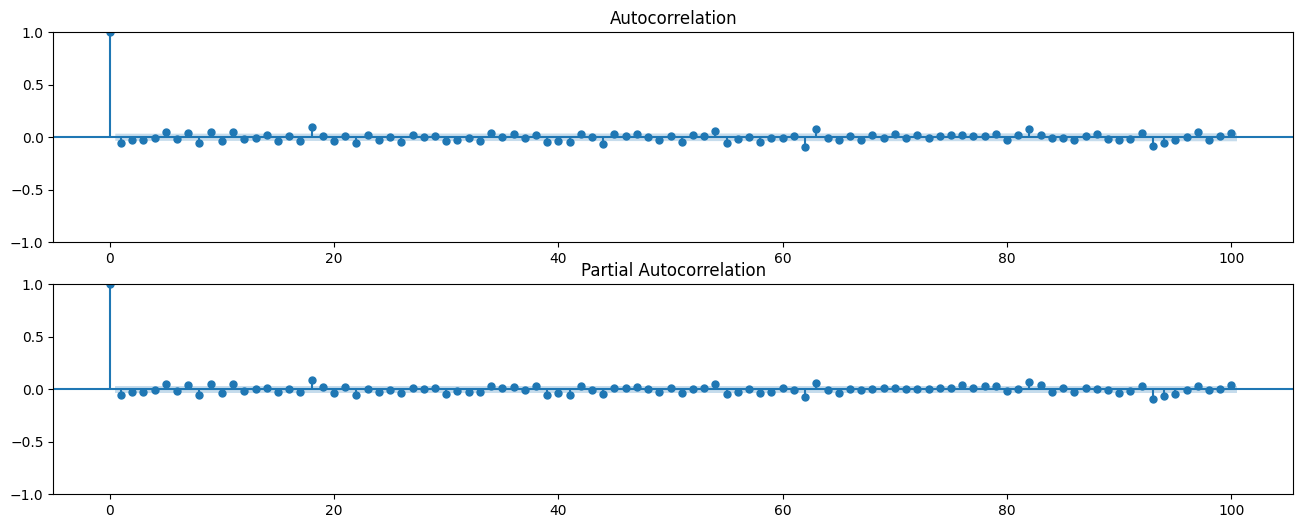

In [13]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(data["Close First Difference"].iloc[1:], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data["Close First Difference"].iloc[1:], lags=100, ax=ax2)

p -> AR lags, 
d -> differencing, 
q -> MA lags.

from the observations of above graph, we can say that p value is 1, d value is 1, q value is 1.

4) Construct the ARIMA model based on the data

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
model = ARIMA(data["Close"], order=(1,1,1))
model_fit = model.fit()

In [18]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3274
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5835.844
Date:                Sat, 06 Jul 2024   AIC                          11677.687
Time:                        16:10:57   BIC                          11695.968
Sample:                             0   HQIC                         11684.234
                               - 3274                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3911      0.117      3.337      0.001       0.161       0.621
ma.L1         -0.4458      0.115     -3.877      0.000      -0.671      -0.220
sigma2         2.0712      0.020    104.300      0.000       2.032       2.110
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18863.12
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              72.03   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

5) Use the model to make predictions

<Axes: >

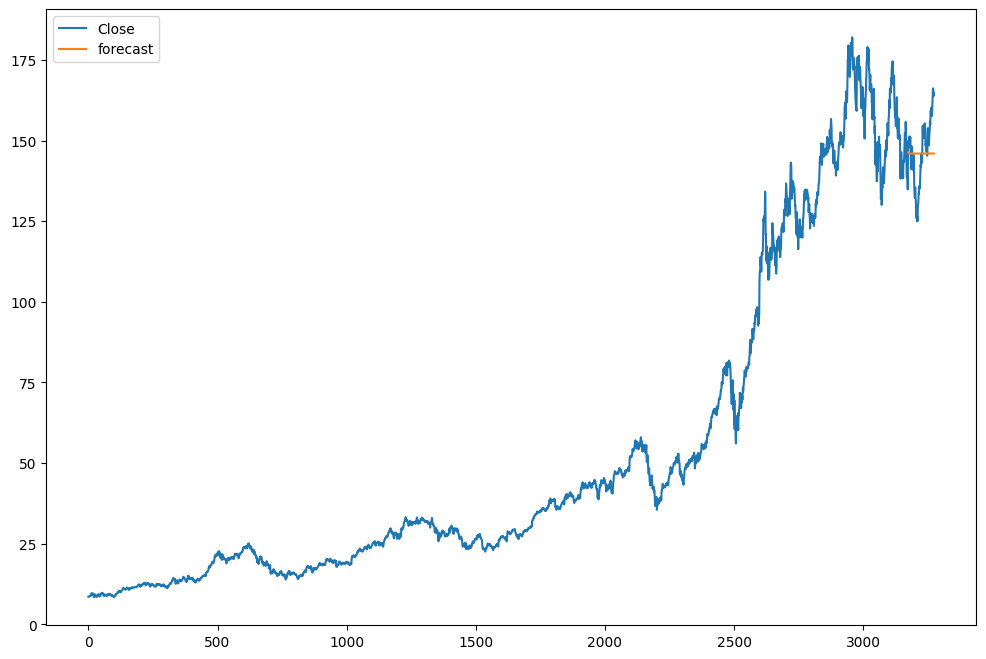

In [19]:
data["forecast"] = model_fit.predict(start=3174, end=3274, dynamic=True)
data[["Close", "forecast"]].plot(figsize=(12,8))

SARIMAX

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
model = SARIMAX(data["Close"], order=(1,1,1), seasonal_order=(1,1,1,50))
result = model.fit()

/home/purav/Desktop/machine learning projects/time series/Apple stock price/apple_sp/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/purav/Desktop/machine learning projects/time series/Apple stock price/apple_sp/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89663D+00    |proj g|=  1.96474D-01

At iterate    5    f=  1.79008D+00    |proj g|=  1.87537D-02

At iterate   10    f=  1.78405D+00    |proj g|=  1.39197D-03

At iterate   15    f=  1.78363D+00    |proj g|=  1.68262D-03

At iterate   20    f=  1.78363D+00    |proj g|=  4.06100D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   4.061D-06   1.784D+00
  F =   1.7836291232852219     

CONVERG

<Axes: >

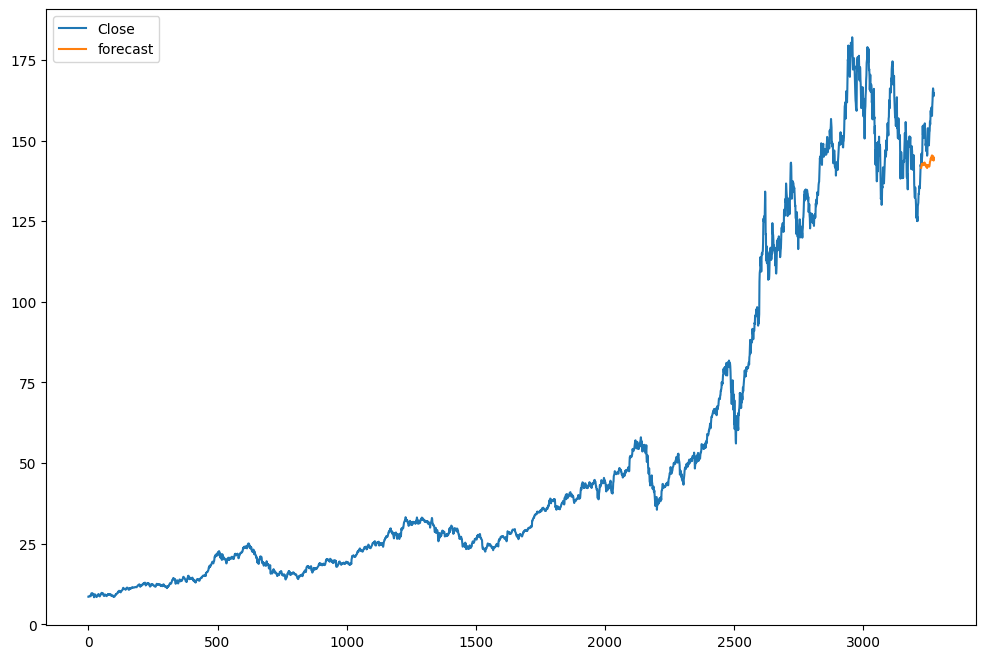

In [22]:
data["forecast"] = result.predict(start=3174+50, end=3304, dynamic=True)
data[["Close", "forecast"]].plot(figsize=(12,8))